In [6]:
using HDF5, StatsBase, Statistics,PyPlot
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools, OrdenaSets

In [7]:
# El de franco que tiene bonito los canales detectados.
arxname="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

"/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

In [8]:
#arxname="/home/karel/BRWFiles/Isabel2019/Cacho_06_control_02_preproc.h5"

In [9]:
arx=h5open(arxname)
names(arx)

7-element Array{String,1}:
 "CSDALindenberg"
 "CanalesBuenos" 
 "CanalesMalos"  
 "LFPSaturados"  
 "desde"         
 "freq"          
 "hasta"         

In [10]:
canales=read(arx["CanalesBuenos"])
#lfp=read(arx["dset"]);
lfp=read(arx["LFPSaturados"]);
#freq=read(arx["SamplingRate"])/1000
freq=read(arx["freq"])

dd=size(lfp)
if length(dd)==2
    nmax=dd[2]
    lfp=reshape(lfp, 64,64,nmax)
end
nmax=size(lfp,3)
typeof(lfp)

Array{Float32,3}

In [11]:
#fac=read(arx["Factor"])
#off=read(arx["Offset"])

In [12]:
# fac, off, freq

In [13]:
sqrt(nmax)

44.721359549995796

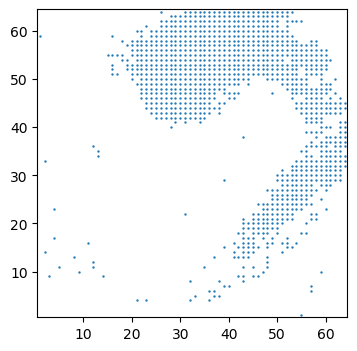

PyObject <matplotlib.collections.PathCollection object at 0x7f520b315590>

In [14]:
ff=figure(figsize=(4,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
# Isabel Nuevos
#scatter(canales[:,3], canales[:,2], s=0.5)
#Franco Viejos
scatter(canales[:,2], canales[:,1], s=0.5)

In [15]:
yxref=[39,40]
# okey menso a barreconjunto le tienes que pasar solo las columnas con coordenadas!!!
orderchans=barreconjuntoyordena(canales[:,1:2], yxref);

alfamin = 0.015623728620476831


In [16]:
v=orderchans[:,2].==40
orderchans[v,:]

19×3 Array{Int64,2}:
 51  40   412
 50  40   413
 49  40   414
 47  40   415
 46  40   416
 64  40   417
 63  40   418
 62  40   419
 61  40   420
 60  40   421
 59  40   422
 58  40   423
 57  40   424
 56  40   425
 55  40   426
 54  40   427
 53  40   428
 52  40   429
  7  40  1024

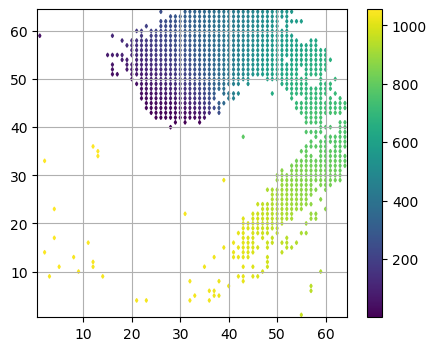

In [17]:
ff=figure(figsize=(5,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
#scatter(canales[:,2], canales[:,1], s=0.5)
scatter(orderchans[:,2], orderchans[:,1], marker="d",s=3, cmap="viridis", c=orderchans[:,3])
colorbar()
grid()

In [18]:
ejemplos=([58,30], [56,41], [54,36],[14,40])

([58, 30], [56, 41], [54, 36], [14, 40])

In [19]:
cbrt(nmax)

12.599210498948732

In [20]:
sqrt(nmax)

44.721359549995796

In [40]:
function freediaconisbin(datos)
    # Freedman and Diaconis
    n=length(datos)
    m=iqr(datos)
    result=2*m/cbrt(n)
    return result
end

function scottbin(datos)
    n=length(datos)
    m=std(datos)
    result=3.49*m/cbrt(n)
end

function sqrbin(datos)
    n=length(datos)
    sq=sqrt(n)
    (mir,mar)=extrema(datos)
    result=(mar-mir)/sq
end

function mejorbin(datos; deltax=1)
    # estas asumiendo que los datos se ven bastante gaussianos!
    # y que estan discretizados en pasos deltax
    sig=std(datos)/13
    (fd, sb, sq)=(freediaconisbin(datos), scottbin(datos), sqrbin(datos))
    bines=[fd, sb, sq, sig]
    masquedx=bines[bines.>deltax]
    if isempty(masquedx)
        result=deltax 
    else 
       result=minimum(masquedx)
    end
    return result
end

mejorbin (generic function with 1 method)

In [71]:
function histoptimo(datos::Array; deltax=1)
    bine=mejorbin(datos, deltax=deltax)
    (vmin,vmax)=extrema(datos)
    rango=vmin:bine:vmax+bine
    result=fit(Histogram, datos,rango)
end

histoptimo (generic function with 1 method)

In [62]:
verbines=zeros(64,64)

for j=1:64,k=1:64
    lfpex=vec(lfp[j,k,:])
    verbines[j,k]=mejorbin(lfpex, deltax=4)
end

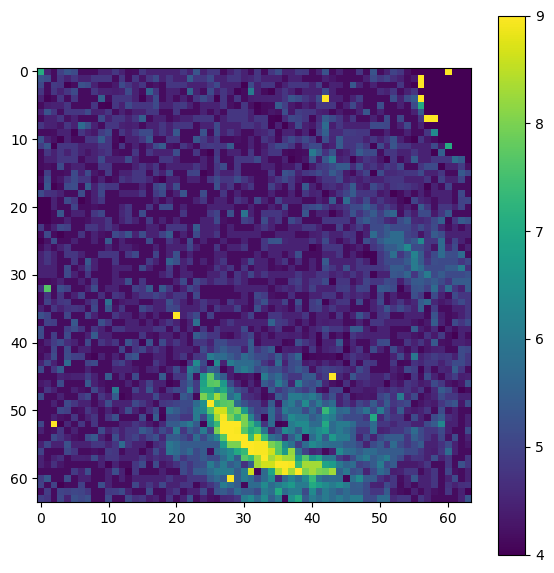

PyObject <matplotlib.colorbar.Colorbar object at 0x7f51fa5b9c50>

In [63]:
figure(figsize=(7,7))
imshow(verbines, vmin=4, vmax=9)
colorbar()

In [64]:
verbines==ones(64,64)

false

In [75]:
function sacaentropia1d(datos::Array; deltax=1)
    hh=histoptimo(datos, deltax=deltax)
    pdfs=hh.weights./sum(hh.weights)
    result=entropy(pdfs)
end

sacaentropia1d (generic function with 1 method)

In [76]:
hetas=zeros(64,64)

for j=1:64,k=1:64
    lfpex=vec(lfp[j,k,:])
    hetas[j,k]=sacaentropia1d(lfpex, deltax=2.02)
end

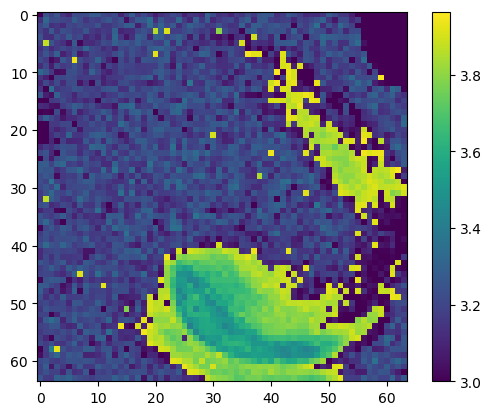

PyObject <matplotlib.colorbar.Colorbar object at 0x7f51fa178bd0>

In [82]:
imshow(hetas, vmin=3)
colorbar()

In [104]:
function binsize2d(datosx::Array, datosy::Array; deltax=1, deltay=1)
    if length(datosx)!=length(datosy)
        error("Solo puedo lidiar con datos de la misma longitud")
    end
    
    nn=length(datosx)
    
    minx,maxx=extrema(datosx)
    miny,maxy=extrema(datosy)
    
    rx=maxx-minx
    ry=maxy-miny
    sq=[rx,ry]./(nn^(1/4))
    
    sigx,sigy= std(datosx), std(datosy)
    sc=[sigx,sigy].*(3.49/(nn^(1/6)))

    iqx, iqy= iqr(datosx), iqr(datosy)
    fd=[iqx, iqy].*(2/nn^(1/6))
    
    bines=[sq, sc, fd]
    areas=map(x->prod(x), bines)
    
    losbuenos=areas.>deltax*deltay
    
    areasmayores=areas[losbuenos]
    binesdepurados=bines[losbuenos]
   
    if !isempty(areasmayores)
        index=findmin(areasmayores)[2]
        result=binesdepurados[index]
    else
        result=[deltax,deltay]
    end
    
    return result
end

binsize2d (generic function with 1 method)

In [109]:
function binsize3d(datosx::Array, datosy::Array, datosz::Array; deltax=1, deltay=1, deltaz=1)
    if length(datosx)!=length(datosy) || length(datosx)!=length(datosz)
        error("Solo puedo lidiar con datos de la misma longitud")
    end
    
    nn=length(datosx)
    
    minx,maxx=extrema(datosx)
    miny,maxy=extrema(datosy)
    minz,maxz=extrema(datosy)
    
    rx=maxx-minx
    ry=maxy-miny
    rz=maxz-minz
    sq=[rx,ry, rz]./(nn^(1/6))
    
    sigx,sigy, sigz= std(datosx), std(datosy), std(datosz)
    sc=[sigx,sigy, sigz].*(3.49/(nn^(1/9)))

    iqx, iqy, iqz= iqr(datosx), iqr(datosy), iqr(datosz)
    fd=[iqx, iqy, iqz].*(2/nn^(1/9))
    
    bines=[sq, sc, fd]
    areas=map(x->prod(x), bines)
    
    losbuenos=areas.>deltax*deltay*deltaz
    
    areasmayores=areas[losbuenos]
    binesdepurados=bines[losbuenos]
   
    if !isempty(areasmayores)
        index=findmin(areasmayores)[2]
        result=binesdepurados[index]
    else
        result=[deltax,deltay, deltaz]
    end
    
    return result
end

binsize3d (generic function with 1 method)

In [107]:
lfpx=vec(lfp[30,22,:])
lfpy=vec(lfp[22,30,:])
lfpz=vec(lfp[45,21,:]);

In [110]:
binsize2d(lfpx,lfpy)
binsize3d(lfpx,lfpy,lfpz)

3-element Array{Float64,1}:
 24.23655680365277 
 22.50537417482043 
 27.698922061317454

In [24]:
caralho=Dict{Array, Any}()
for q in ejemplos
    caralho[q]=histofreediaconis(lfp[q[1], q[2], :])
end

1 Base.TwicePrecision{Float64}(0.4607807661920545, 0.0)
159.8500616351135 17.0 [58, 30] 2051.0 0.4607807661920545
1 Base.TwicePrecision{Float64}(0.3523617623821593, 0.0)
13304.115182497977 13.0 [56, 41] 2049.0 0.3523617623821593
1 Base.TwicePrecision{Float64}(0.4065712642871069, 0.0)
11412.924181035947 15.0 [54, 36] 2049.0 0.4065712642871069
1

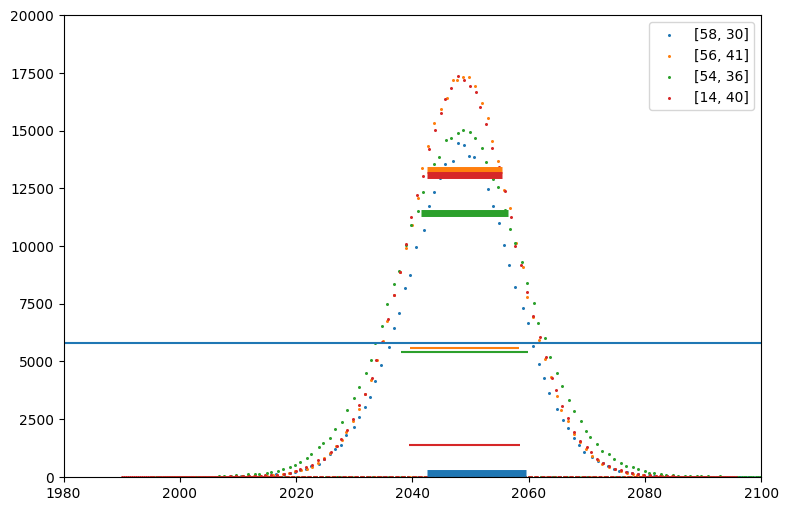

 Base.TwicePrecision{Float64}(0.3523617623821593, 0.0)
13065.98283909582 13.0 [14, 40] 2049.0 0.3523617623821593


PyObject <matplotlib.legend.Legend object at 0x7f63e9d39048>

In [100]:
figure(figsize=(9,6))
xlim(1980,2100)
ylim(-20,2.0*10^4)
for q in ejemplos
     lfpex=vec(lfp[q[1], q[2],:])
      sig=std(lfpex)
    inter=iqr(lfpex)
    mm=median(lfpex)
    
    ff=freediaconis(lfpex)
    
    edg=caralho[q].edges[1][1:end-1]
    ww=caralho[q].weights
    aa=scatter(edg,ww, label="$q", s=1.4)
    l=caralho[q].edges[1].step
    println(1, " ", l)
    
    altura=exp(-0.25)/(sig*sqrt(2*pi))
    
    colore=aa.get_facecolors()
    ylin=100*q[1]
    hlines(ylin,mm-sig, mm+sig, color=colore)
    
    ylin2=altura*nmax
    hlines(ylin2, mm-inter/2, mm+inter/2, color=colore, lw=5)
    println(ylin2, " ", inter, " ", q, " ", mm, " ", ff)
end
legend()

In [107]:
for q in ejemplos
    lfpex=vec(lfp[q[1], q[2],:])
    sig=std(lfpex)
    inter=iqr(lfpex)
    mm=median(lfpex)  
    ff=freediaconisbin(lfpex)
    ss=scottbin(lfpex)
    sq=sqrbin(lfpex)
    println(q, " ", sig, " ", inter, " ", mm, " ", ff ,  " ", ss, " ", sq)
end

[58, 30] 780.8675233622242 17.0 2051.0 0.4607807661920545 36.93330845957613 3.3052717032174175
[56, 41] 9.382188896148257 13.0 2049.0 0.3523617623821593 0.44375680401644035 0.14830336043075762
[54, 36] 10.936874700851641 15.0 2049.0 0.4065712642871069 0.5172900073639164 0.18143496222911837
[14, 40] 9.553182739902311 13.0 2049.0 0.3523617623821593 0.4518444350000733 0.1672357043155352


[58, 30] 780.8675233622242 17.0
[56, 41] 9.382188896148257 13.0
[54, 36] 10.936874700851641 15.0


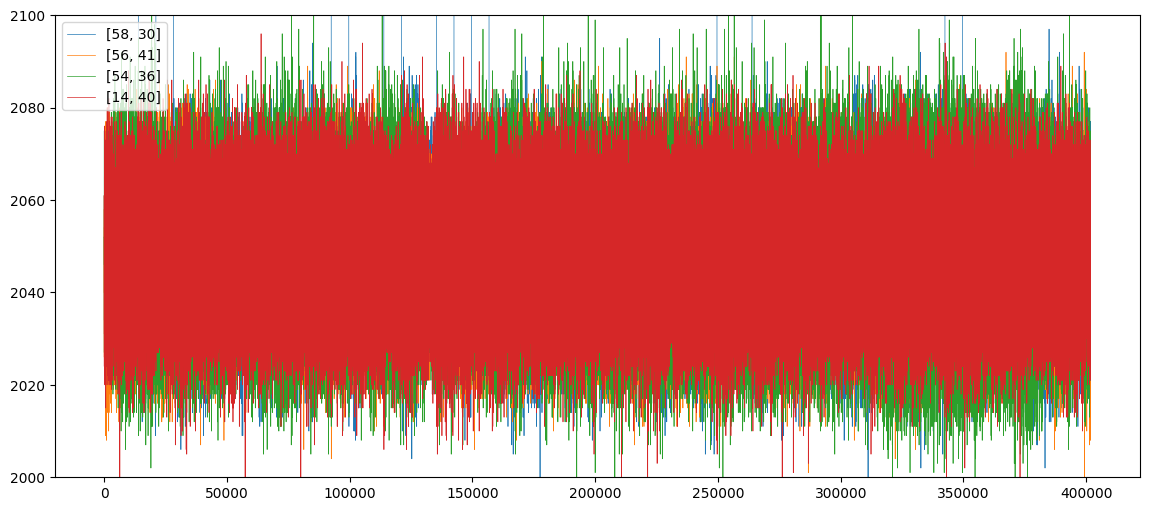

[14, 40] 9.553182739902311 13.0


PyObject <matplotlib.legend.Legend object at 0x7f63eb2da320>

In [54]:
figure(figsize=(14,6))
ylim(2000,2100)
for q in ejemplos
    lfpex=vec(lfp[q[1], q[2],:])
    rangg=collect(1:nmax)
    plot(rangg, lfpex, lw=0.5, label="$q")
    sig=std(lfpex)
    inter=iqr(lfpex)
    println(q, " ", sig, " ", inter)
end
legend()

In [15]:
uno=sum(rr3.weights, dims=[1,3])
otro=rryy.weights
vec(uno)==otro
(typeof(uno), typeof(otro))

(Array{Int64,3}, Array{Int64,1})

In [16]:
fururu=[rrr.edges[2][1], rrr.edges[2][end], rrr.edges[1][1], rrr.edges[1][end]]
f9=[0,1,0,1]
imshow(rrr.weights./sum(rrr.weights), extent=fururu, origin="lower", interpolation="nearest")
colorbar()
#scatter(yy,xx, c="red", s=1)

UndefVarError: UndefVarError: rrr not defined

In [17]:
function transferentropyfd(yyfuture::Array, yypast::Array, xxpast::Array)
    hfd=histofreediaconis(yyfuture,yypast,xxpast)
    pesos=hfd.weights./sum(hfd.weights)
    #checa que conserva su "dimensionalidad" en los indices
    pypast=sum(pesos, dims=[1,3])
    pypastxpast=sum(pesos, dims=1)
    pyfutpypast=sum(pesos, dims=3)

    (KK,LL,MM)=size(pesos)
    
    sumatum=0
    
    for k=1:KK, l=1:LL, m=1:MM
        aux1=pesos[k,l,m]*pypast[1,l,1]
        aux2=pypastxpast[1,l,m]*pyfutpypast[k,l,1]
        if aux1 !=0  && aux2 !=0
            aux3=log(aux1/aux2)
            sumatum+=pesos[k,l,m]*aux3
        end
    end
    
    return sumatum
    
end


transferentropyfd (generic function with 1 method)

In [18]:
tau=round(Int, 5*freq)
xx=lfp[56,30,:]
yy=lfp[56,40,:]
xf=xx[tau:end]
xp=xx[1:end-tau+1]
yp=yy[1:end-tau+1]
transferentropyfd(xf,xp,yp)

1.2312138905946999

In [19]:
rrr=histofreediaconis(xx,yy)
rx=sum(rrr.weights, dims=2)
ry=sum(rrr.weights, dims=1)

1×86 Array{Int64,2}:
 2  0  1  2  1  1  1  1  1  4  1  3  2  …  0  3  2  1  0  1  0  1  1  1  0  2

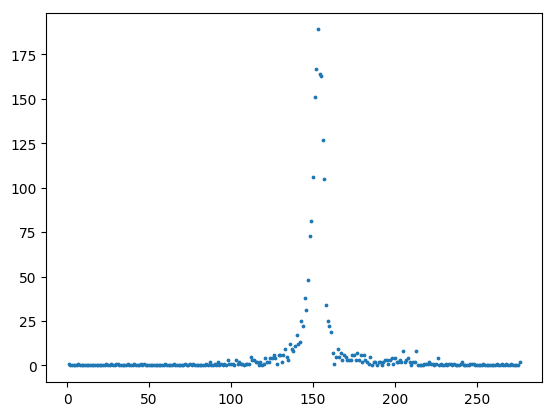

PyObject <matplotlib.collections.PathCollection object at 0x7fd578518c88>

In [20]:
scatter(1:length(rx),vec(rx), s=3)

In [68]:
function histocountmap(xxs::Array)
    dicto=countmap(xxs)
    ll=length(dicto)
    bla=zeros(ll,2)
    j=1
    for k in sort(collect(keys(dicto)))
        bla[j,1]=k
        bla[j,2]=dicto[k]
        j+=1
    end
    return bla
end

function histocountmap(xxss::Array...)
    valores=collect(zip(xxss...))
    dicto=countmap(valores)
    ll=length(dicto)
    tantas=length(xxss)
    bla=zeros(ll, tantas+1)
    j=1
    for k in sort(collect(keys(dicto)))
        for l in 1:tantas
            bla[j,l]=k[l]
        end
        bla[j,tantas+1]=dicto[k]
        j+=1
    end
    return bla
end

LoadError: syntax: incomplete: "function" at none:1 requires end

In [72]:
rangg=250:1500
xxpas=xx[rangg]
yypas=yy[rangg]
yyfut=yy[rangg.+28];

In [76]:
haha=histocountmap(yyfut,yypas,xxpas)
countmap(haha[:,end])

Dict{Float64,Int64} with 2 entries:
  2.0 => 4
  1.0 => 1243

In [22]:
function entrocountmap(xxs::Array)
    cuentas=histocountmap(xxs)
    pdfval=cuentas[:,2]./sum(cuentas[:,2])
    suma=0
    for j in pdfval
        suma+=j*log(j)
    end
    return (-suma)
end

function entrocountmap(xxss::Array...)
    cuentas=histocountmap(xxss...)
    #ligeramente diferente ¿sera generalizable?
    pdfval=cuentas[:,end]./sum(cuentas[:,end])
    suma=0
    for j in pdfval
        suma+=j*log(j)
    end
    return (-suma)
end


entrocountmap (generic function with 2 methods)

In [ ]:
function transferentropycm(yyfuture, yypast, xxpast)
    hcm=histocountmap(yyfuture,yypast,xxpast)
    pesos=hcm[:,end]
    pesos=pesos./sum(pesos)
    #checa que conserva su "dimensionalidad" en los indices
    pypast=histocountmap(yypast)
    pypastxpast=histocountmap(yypast,xxpast)
    pyfutpypast=histocountmap(yyfuture,yypast)
    
    

    (KK,LL,MM)=size(pesos)
    
    sumatum=0
    
    for k=1:KK, l=1:LL, m=1:MM
        aux1=pesos[k,l,m]*pypast[1,l,1]
        aux2=pypastxpast[1,l,m]*pyfutpypast[k,l,1]
        if aux1 !=0  && aux2 !=0
            aux3=log(aux1/aux2)
            sumatum+=pesos[k,l,m]*aux3
        end
    end
    
    return sumatum
    


end

In [23]:
fu=histocountmap(xx,yy)
bar=entrocountmap(xx,yy)

7.258144577604487

In [25]:
fufu=fu[fu[:,3].>2,:]
typeof(fufu)

Array{Float64,2}

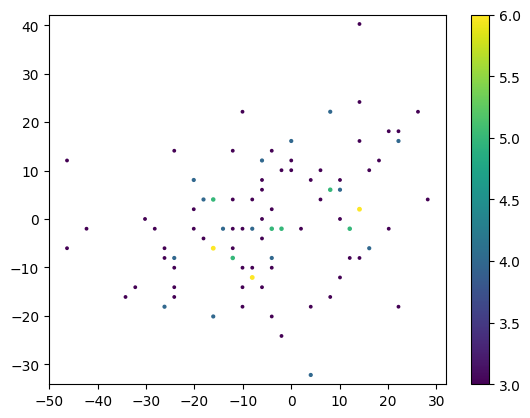

(-50.053800503667674, 31.926359097417667, -35.85500884745723, 43.91128698707785)

In [26]:
eqs=fufu[:,1]
yes=fufu[:,2]
siz=fufu[:,3]
scatter(eqs,yes, s=siz, c=siz)
colorbar()
axis("equal")

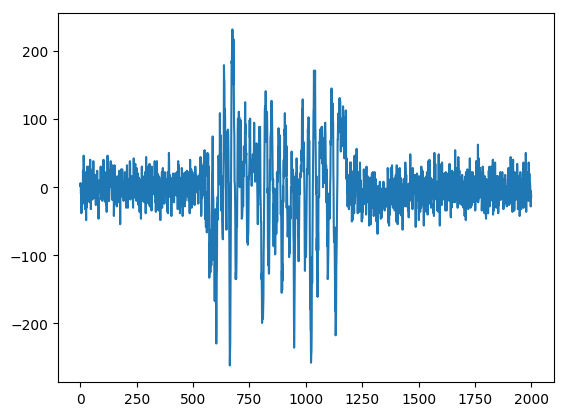

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd5767bdf60>

In [27]:
plot(yy)

In [28]:
hetasfd=zeros(64,64)
hetascm=zeros(64,64)
for j=1:64, k=1:64
    ejemplo=lfp[j,k,:]
    hetasfd[j,k]=sacaentropiafd(ejemplo)
    hetascm[j,k]=entrocountmap(ejemplo)
end


In [29]:
dh=hetasfd-hetascm;
#map!(x->round(x ;digits=3), dh)

64×64 Array{Float64,2}:
 -0.00430033  -0.828288  -0.721642  …   0.0        0.0        0.0     
 -0.645778    -0.949897  -0.725919      0.0        0.0        0.0     
 -0.655579    -0.727874  -0.656125      0.0        0.0        0.0     
 -0.873623    -0.722449  -0.883149      0.0        0.0        0.0     
 -0.809698    -0.879922  -0.726231      0.0        0.0        0.0     
 -0.736013    -0.870958  -0.80382   …   0.0        0.0        0.0     
 -0.801438    -0.650344  -0.86598       0.0        0.0        0.0     
 -0.725109    -0.795596  -0.802805      0.0        0.0        0.0     
 -0.868443    -0.815723  -0.648623      0.0        0.0        0.0     
 -0.742314    -0.729287  -0.814583      0.0        0.0        0.0     
 -0.654961    -0.798873  -0.742495  …   0.0        0.0        0.0     
 -0.593115    -0.645372   0.0           0.0        0.0        0.0     
 -0.7153      -0.884071  -0.793444      0.0        0.0        0.0     
  ⋮                                 ⋱                

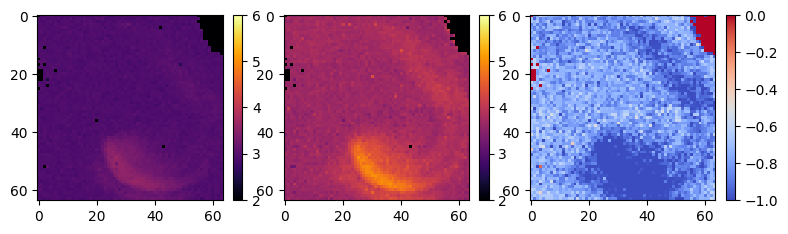

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd576608f28>

In [30]:
fig, (uno, dos, tres)=subplots(1,3, figsize=(9,4))
bmin=2
bmax=6
fafa=uno.imshow(hetasfd, origin="upper", cmap="inferno", vmin=bmin, vmax=bmax)
colorbar(fafa, ax=uno, fraction=0.045)
fufu=dos.imshow(hetascm, origin="upper", cmap="inferno", vmin=bmin, vmax=bmax)
colorbar(fufu, ax=dos, fraction=0.045)
fefe=tres.imshow(dh, origin="upper", cmap="coolwarm", vmin=-1, vmax=0)
colorbar(fefe, ax=tres, fraction=0.045)


In [31]:
mean(hetascm)

3.7399459847198226

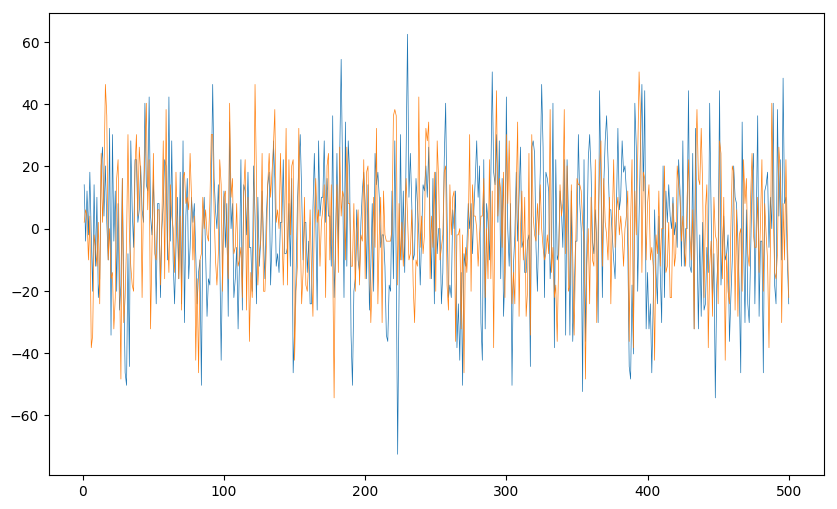

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd57680e2e8>

In [32]:
f=figure(figsize=(10,6))
rang=1:5*10^2
plot(rang,xx[rang], lw=0.5)
plot(rang,yy[rang], lw=0.5)

In [33]:
vallfpdisc=zeros(64,64)
hfdiacounts=zeros(64,64)
iqrs=zeros(64,64)
for j=1:64, k=1:64
    haux=0
    try
        haux=histofreediaconis(lfp[j,k,:])
          hfdiacounts[j,k]=length(haux.edges[1])
    catch e
    end
    iqrs[j,k]=iqr(lfp[j,k,:])
  
    vallfpdisc[j,k]=length(countmap(lfp[j,k,:]))
end

In [34]:
iqr(vec(iqrs))
mean(vec(iqrs))
mode(vec(iqrs))


26.18408203125

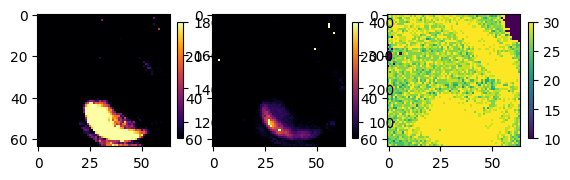

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd5764e3b38>

In [35]:
figure(figsize=(12,8))
fig, (uno, dos,tres)=subplots(1,3)
fafa=uno.imshow(vallfpdisc, origin="upper", vmin=110, vmax=180, cmap="inferno")
colorbar(fafa, ax=uno, fraction=0.04)
fufu=dos.imshow(hfdiacounts, origin="upper", vmin=50, vmax=400, cmap="inferno")
colorbar(fufu, ax=dos, fraction=0.04)
fefe=tres.imshow(iqrs, vmin=10,vmax=30)
colorbar(fefe, ax=tres, fraction=0.04)


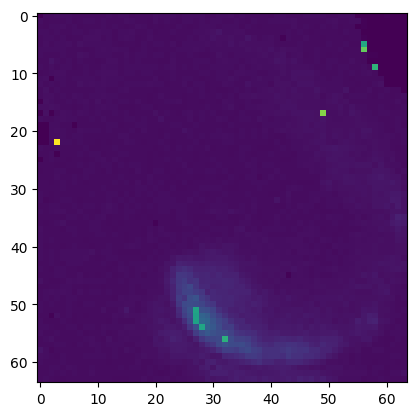

PyObject <matplotlib.image.AxesImage object at 0x7fd57640dcc0>

In [36]:
imshow(hfdiacounts)

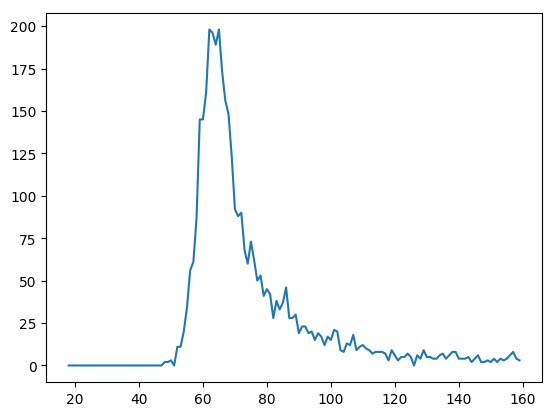

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd5763f4320>

In [37]:
vv=vec(vallfpdisc)
ll=length(countmap(vv))
jhh=fit(Histogram, vv, 18:160)
ta=jhh.weights
tu=jhh.edges[1]
size(collect(tu[1:end-1])), size(ta)
plot(tu[1:end-1], ta)

In [38]:
typeof(vv)

Array{Float64,1}

In [55]:
function sacaentropiafd(datosX::Array, datosY::Array)
    # ambos arrays deben ser igual de largos ???
    binsizeX=freediaconis(datosX)
    binsizeY=freediaconis(datosY)
    if (binsizeX==0 || binsizeY==0)
        error(" ¡Esto que, no tiene variacion en los datos!")
    else
        (viX,vfX)=extrema(datosX)
        (viY,vfY)=extrema(datosY)
        rangoX=viX:binsizeX:vfX
        rangoY=viY:binsizeY:vfY
        
        histodo=fit(Histogram, (datosX, datosY), (rangoX, rangoY))
        
        pdf=histodo.weights
        pdf=pdf./sum(pdf)
        result=entropy(pdf)
        return result
        #return (result, histodo)
    end

end

sacaentropiafd (generic function with 2 methods)

In [56]:
function infomutua(datosX::Array, datosY::Array)
    hetaX=sacaentropiafd(datosX)
    hetaY=sacaentropiafd(datosY)
    hetaXY=sacaentropiafd(datosX,datosY)
    result=hetaX+hetaY-hetaXY
    return result
end

infomutua (generic function with 1 method)

In [57]:
nchan=size(orderchans, 1)
hetas=zeros(nchan)
for j=1:nchan
    reng,col=orderchans[j,1],orderchans[j,2]
    ejemplo=lfp[reng,col,:]
    hetas[j]=sacaentropiafd(vec(ejemplo))
end

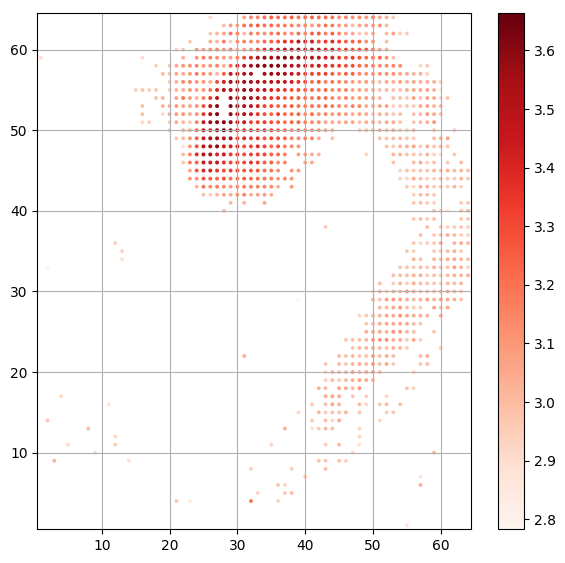

In [58]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[:,2], orderchans[:,1], s=hetas, c=hetas, cmap="Reds")
colorbar()
grid()

In [59]:
hetacut=quantile(hetas, 0.90)
tuabueta=findall(x->x>hetacut,hetas);
auxchans=hcat(orderchans[tuabueta,:], hetas[tuabueta])
naux=size(auxchans,1)

105

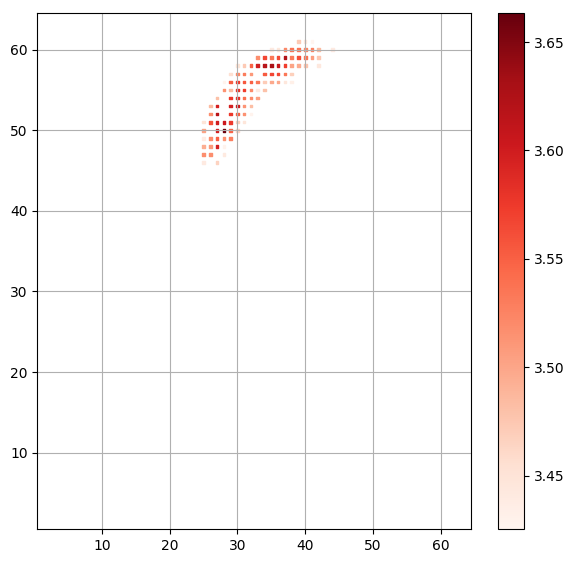

In [60]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(auxchans[:,2], auxchans[:,1], s=auxchans[:,4], 
    c=auxchans[:,4],marker="s", cmap="Reds")
colorbar()
grid()

In [61]:
imutres=zeros(nchan)
refe=[50,28]
fijo=lfp[refe[1], refe[2],:]
for j=1:nchan
    reng,col=orderchans[j,1],orderchans[j,2]
    ejemplo=lfp[reng,col,:]
    imutres[j]=infomutua(fijo, ejemplo)
end

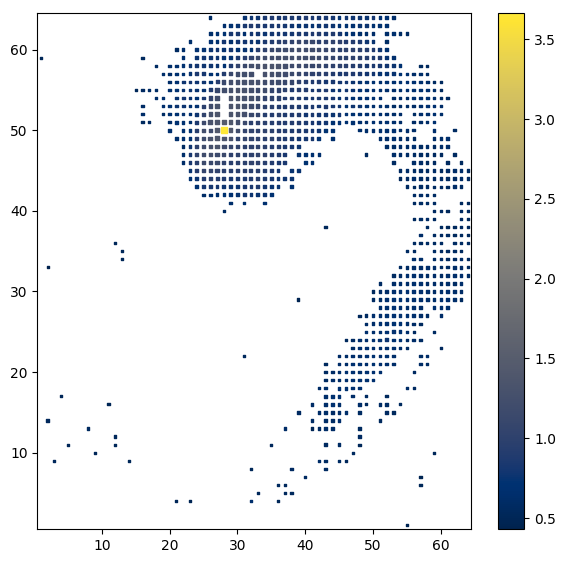

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd576239358>

In [62]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[:,2], orderchans[:,1], s=imutres.*5, c=imutres, cmap="cividis", marker="s")
colorbar()
#grid()

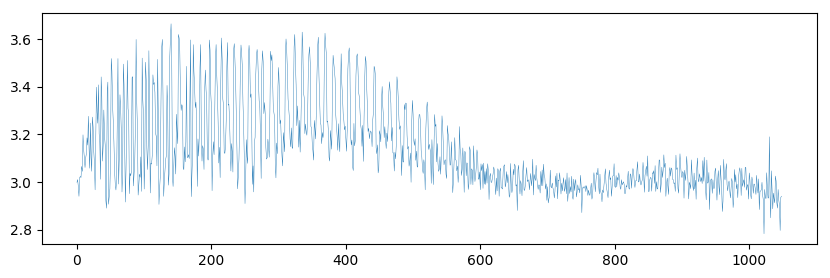

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd57631fac8>

In [63]:
figure(figsize=(10,3))
plot(hetas, lw=0.3)

In [64]:
mutinfo=zeros(naux,naux);
crossentro=zeros(naux,naux)

@time for j=1:naux
    for k=j:naux
        
        reng1,col1=(auxchans[j,1], auxchans[j,2])
        reng2,col2=(auxchans[k,1], auxchans[k,2])
        
        reng1=round(Int32, reng1)
        reng2=round(Int32, reng2)
        
        col1=round(Int32, col1)
        col2=round(Int32, col2)
        
        
        
        dat1=lfp[reng1, col1,:]
        dat2=lfp[reng2, col2,:]
        
        mutinfo[j,k]=infomutua(dat1,dat2)
        mutinfo[k,j]=mutinfo[j,k]
    
    end
end

  5.966175 seconds (277.01 k allocations: 3.476 GiB, 2.68% gc time)


In [65]:
for j=1:naux
    mutinfo[j,j]=0
end

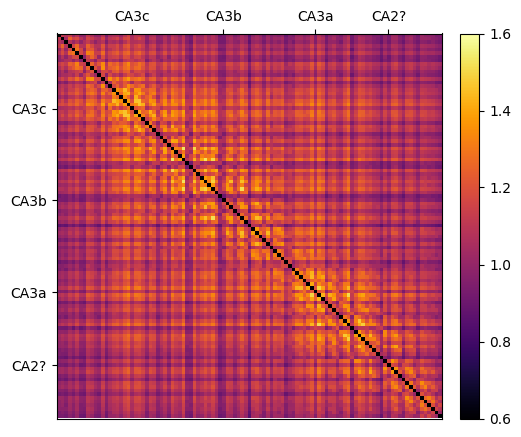

PyObject <matplotlib.colorbar.Colorbar object at 0x7fd5789ccda0>

In [66]:
figure(figsize=(6,5))

imshow(mutinfo, cmap="inferno", interpolation="nearest", vmin=0.6, vmax=1.6)

#onde=[55, 125, 200, 250]
onde=[20, 45, 70, 90]
que=["CA3c","CA3b", "CA3a", "CA2?" ]
tick_params(bottom=false, top=true)
xticks(onde, que)
yticks(onde, que)
tick_params(bottom=false, top=true, labeltop=true, labelbottom=false)

colorbar(fraction=0.046, pad=0.04)

In [67]:
?crossentropy

search: crossentropy crossentro



```
crossentropy(p, q, [b])
```

Compute the cross entropy between `p` and `q`, optionally specifying a real number `b` such that the result is scaled by `1/log(b)`.
